<a href="https://colab.research.google.com/github/marcinwolter/AI_Lublin_2023/blob/main/TransferLearningExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='green'>Transfer learning</font>**



<img src = 'https://editor.analyticsvidhya.com/uploads/444861_2vse-G3FKMT2D59NFWduMA.jpg' width=450px>

With transfer learning, we basically try to use what we’ve learned in one task to better understand the concepts in another. Weights are being automatically being shifted to a network performing “task A” from a network that performed new “task B.”


# <font color='green'>**An example – pattern recognition**
# <font color='green'>**on CIFAR10 photos dataset**

**CIFAR10** small image classification. <br>Dataset of 50\,000 32x32 color training images\, labeled over 10 categories\, and 10\,000 test images\.</span>

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture7/MachineLearning2020_733.png' width=450px>






**This program uses a subsample of CIFAR10 dataset: only three first classes (airplane, automobil, bird) and only 10 000 events for training.**
Without transfer learning a regular convolutional neural network (commented out in the code) is unable to make a decent classification. With transfer learning the accuracy of about **92% - 94%** is achieved.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

170498071/170498071 [==============================] - 2s 0us/step


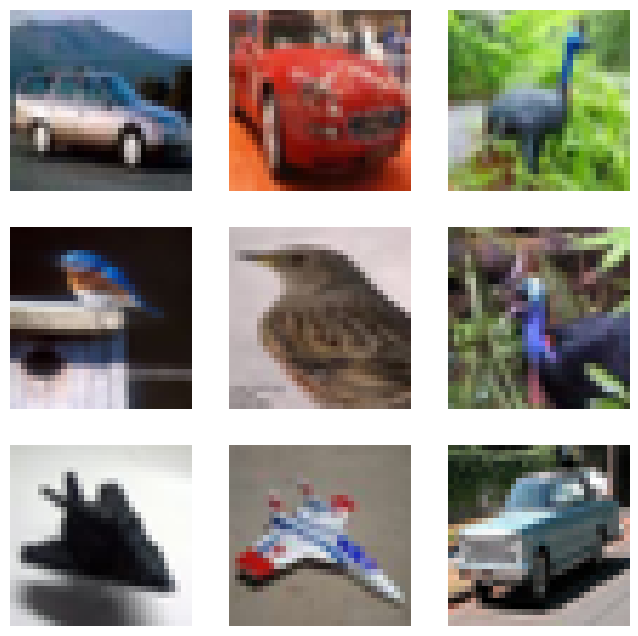

In [2]:
 # labels
num_classes=3

#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels = 32,32,3

# REDUCE THE SIZE OF TRAINING SAMPLE TO 10 000 events
x_train = x_train[0:10000]
y_train = y_train[0:10000]

# take some labels only
x_train = x_train[np.where(y_train.reshape(-1)<num_classes)]
y_train = y_train[np.where(y_train.reshape(-1)<num_classes)]
x_test = x_test[np.where(y_test.reshape(-1)<num_classes)]
y_test = y_test[np.where(y_test.reshape(-1)<num_classes)]


# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(8, 8))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i])
plt.show()

In [3]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3011, 32, 32, 3)
3011 train samples
3000 test samples


In [4]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [5]:

print(y_train.shape)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)

(3011, 1)
(3011, 3)


##**Image augmentation**
Augmentation is a procedure, in which training images are multiplicated by some transformations (rotation, zoom, flip etc) to get more images for training.

In [6]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25
    )
datagen.fit(x_train)

In [7]:
# build and compile the model

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=4
ac='relu'
adm=tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.2
drop_conv=0



## **Regular convolutional network**

In [8]:
'''

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(32, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

'''

"\n\nmodel = Sequential()\n\nmodel.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))\nmodel.add(BatchNormalization(axis=-1))\nmodel.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))\nmodel.add(BatchNormalization(axis=-1))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters\nmodel.add(Dropout(drop_conv))\n\nmodel.add(Flatten())\nmodel.add(Dense(32, activation=ac,kernel_regularizer=reg))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(drop_dense))\nmodel.add(Dense(num_classes, activation='softmax'))\n\n\nmodel.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)\n\n"

## **Pretrained network Xception**

https://keras.io/api/applications/

In [9]:

base_model = k.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128 , channels),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = k.Input(shape=(32, 32, 3))
# upsampling to get 32x32 -> 128x128
#Upsampling because Xception accepts only images greater than 71x71
upsamp1 = tf.keras.layers.UpSampling2D((2,2))(inputs)
upsamp2 = tf.keras.layers.UpSampling2D((2,2))(upsamp1)
x = base_model(upsamp2, training=False)

# Dense layers to be trained
x = k.layers.Flatten()(x)
x = k.layers.Dense(128, activation=ac,kernel_regularizer=reg)(x)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dropout(drop_dense)(x)
outputs = k.layers.Dense(num_classes, activation='softmax')(x)

model = k.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)


83683744/83683744 [==============================] - 1s 0us/step


###**Print model summary**

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 up_sampling2d_1 (UpSampling  (None, 128, 128, 3)      0         
 2D)                                                             
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               419443

#**Training**

In [11]:
# train with image augmentation   steps_per_epoch = len(x_train) / 128,
history=model.fit(datagen.flow(x_train, y_train, batch_size=128),
                     epochs=10, validation_data=(x_test, y_test))

# training without augmentation
# history=model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
24/24 [==============================] - 25s 483ms/step - loss: 0.6511 - accuracy: 0.7808 - val_loss: 0.3252 - val_accuracy: 0.9053
Epoch 2/10
24/24 [==============================] - 9s 385ms/step - loss: 0.4077 - accuracy: 0.8412 - val_loss: 0.2807 - val_accuracy: 0.9000
Epoch 3/10
24/24 [==============================] - 8s 346ms/step - loss: 0.3869 - accuracy: 0.8545 - val_loss: 0.2297 - val_accuracy: 0.9180
Epoch 4/10
24/24 [==============================] - 9s 396ms/step - loss: 0.3540 - accuracy: 0.8662 - val_loss: 0.2592 - val_accuracy: 0.9070
Epoch 5/10
24/24 [==============================] - 9s 395ms/step - loss: 0.3441 - accuracy: 0.8701 - val_loss: 0.2036 - val_accuracy: 0.9273
Epoch 6/10
24/24 [==============================] - 8s 337ms/step - loss: 0.3150 - accuracy: 0.8801 - val_loss: 0.2016 - val_accuracy: 0.9260
Epoch 7/10
24/24 [==============================] - 9s 392ms/step - loss: 0.3213 - accuracy: 0.8781 - val_loss: 0.1992 - val_accuracy: 0.9270
Epoch

###**Calculate the model accuracy**

In [12]:
#test and training accuracy
scores_test=model.evaluate(x_test,y_test,batch_size=128)
scores_train=model.evaluate(x_train,y_train,batch_size=128)

print("Accuracy training data: %.2f%% , test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

24/24 [==============================] - 4s 162ms/step - loss: 0.1632 - accuracy: 0.9422
Accuracy training data: 94.22% , test: 92.57% 


In [13]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

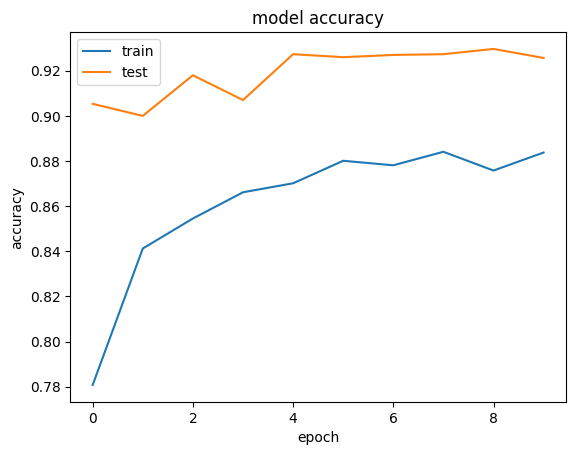

In [14]:
plothist(history)

##<font color = 'red'> **Transfer learning significantly improves our results! About 92% - 94% accuracy**

##**Plot images and their probabilities**

94/94 [==============================] - 4s 42ms/step


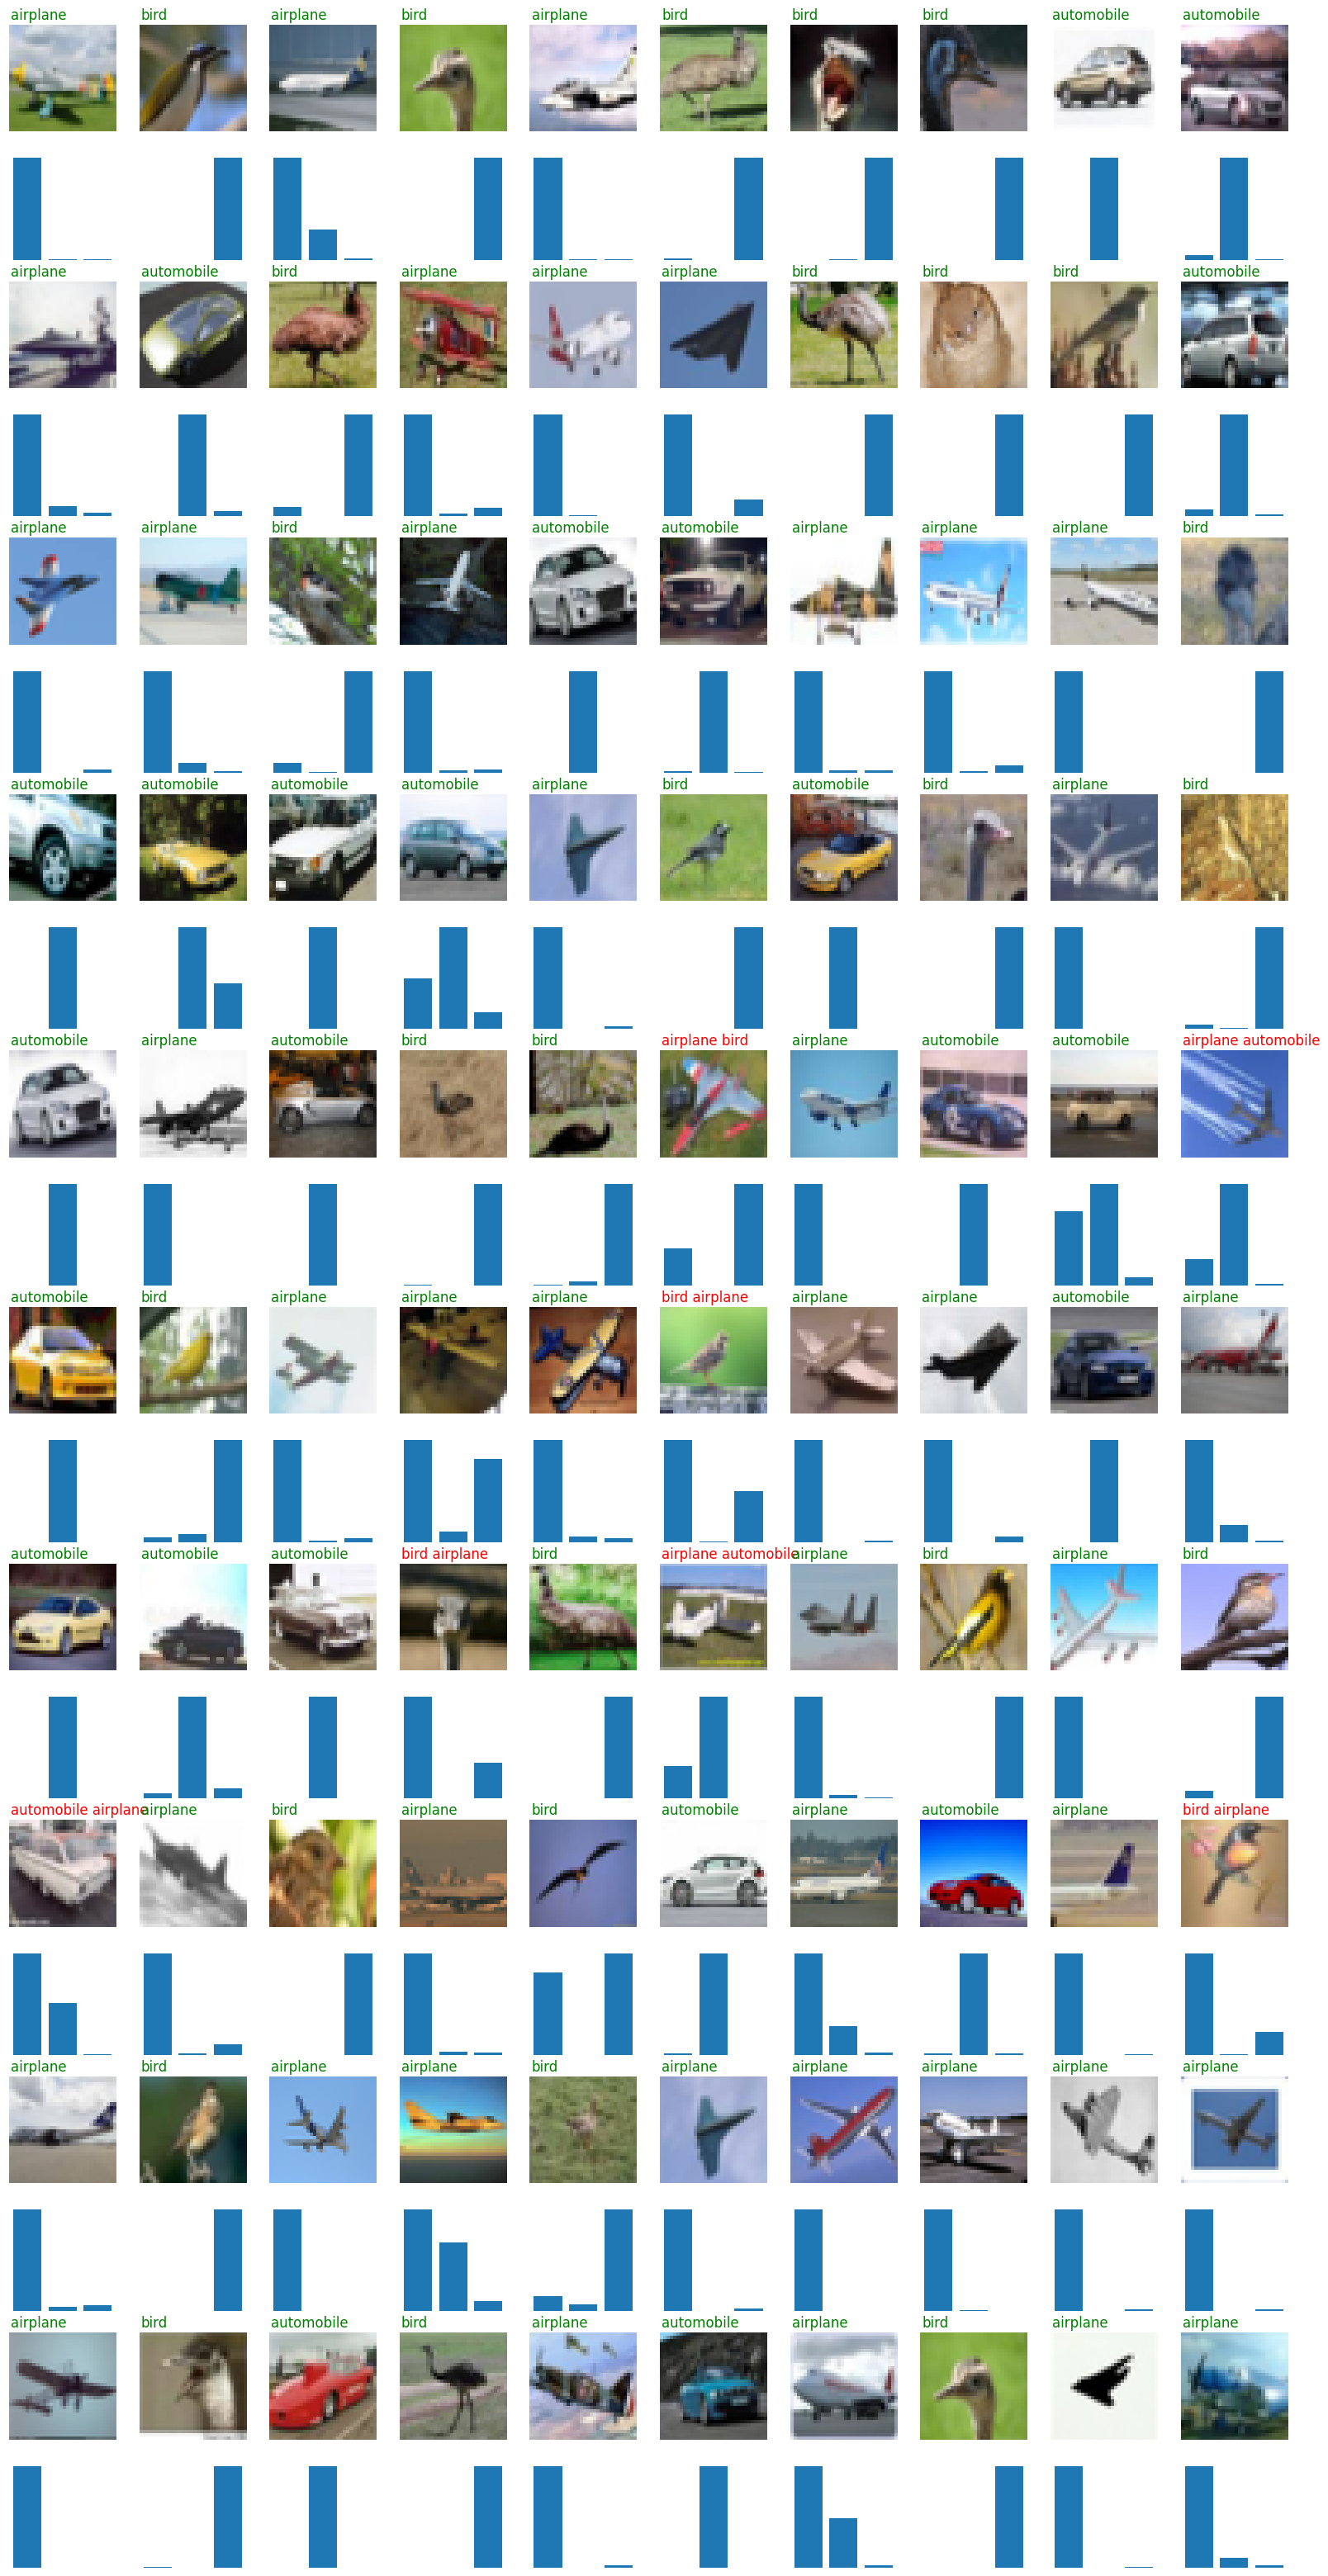

In [15]:

# Names of predicted classes (randomly chosen images)

import random


class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# this construction returns the most probable class for each event
y_pred = np.argmax(model.predict(x_test), axis = 1)
y_pred_prob = model.predict(x_test)

grid_w = 10
grid_h = 10

fig = plt.figure(figsize=(20, 40))
for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    plt.bar([0,1,2,],y_pred_prob[i_img])
    plt.axis('off')

plt.show()